# Сборный проект: анализ рынка компьютерных игр

Изучим данные о предпочтениях критиков и любителей видеоигр в разных частях мира.

### Загрузка данных и первое знакомство с ними

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

games = pd.read_csv('/datasets/games.csv')
rating = pd.read_csv('/datasets/rating.csv')

In [2]:
games.describe()

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


In [3]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [4]:
games.sample(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
3993,Shrek SuperSlam,PS2,2005.0,Action,0.24,0.19,0.00,0.06,67.0,9,E10+
16317,Spider-Man: Friend or Foe,PC,2007.0,Action,0.01,0.00,0.00,0.00,57.0,5.3,E10+
9061,Zetta Hero Project: Unlosing Ranger vs. Darkde...,PSP,2010.0,Role-Playing,0.07,0.00,0.06,0.01,NaN,NaN,NaN
5161,Dragon Ball Z: Infinite World,PS2,2008.0,Fighting,0.08,0.06,0.21,0.02,48.0,7.9,T
5035,Iron Man 2,PSP,2010.0,Action,0.18,0.12,0.00,0.07,49.0,tbd,T
10284,PDC World Championship Darts: Pro Tour,Wii,2010.0,Sports,0.00,0.09,0.00,0.01,NaN,NaN,NaN
943,Max Payne 3,PS3,2012.0,Shooter,0.59,0.89,0.06,0.30,87.0,7.8,M
14958,Battlefield 1942,PC,2002.0,Shooter,0.01,0.01,0.00,0.00,89.0,8.6,T
15457,Stormrise,PC,2009.0,Strategy,0.00,0.02,0.00,0.00,42.0,4.9,M
6714,Dynasty Warriors 6,PS2,2008.0,Action,0.12,0.09,0.00,0.03,43.0,5.4,T


In [5]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
rating_type    8 non-null object
decryption     8 non-null object
dtypes: object(2)
memory usage: 256.0+ bytes


In [6]:
rating

,rating_type,decryption
0,E,Для всех
1,M,От 17 лет
2,T,Подросткам 13—19 лет
3,E10+,Для всех старше 10 лет
4,K-A,Для всех(до 1998 года)
5,AO,Только для взрослых
6,EC,Для детей младшего возраста
7,RP,Рейтинг ожидается


В столбцах с годом релиза, оценками и рейтингом есть пропуски. 

Если между двумя видами оценок существует устойчивая корреляция, теоретически можно пытаться восстановить оценки критиков по оценкам пользователей и наоборот. Но сравнение срезов показывает, что подавляющее большинство пропусков в `user_score` и `critic_score` встречаются в одних и тех же строках. Пропуски в других столбцах заполнить без обращения к внешним источникам информации невозможно в принципе. 

Пропуски в `year_of_release` и `rating` явно носят технологический характер, поскольку эти два признака должны быть у любой игры, которая выходит на рынок. Что касается оценок, то причина их отсуствия в датасете может быть естественной: пользователей и критиков никто не обязывает оценивать каждую выходящую игру. 

Скорее всего, дело либо в годе выпуска игры (ведь когда рынок компьютерных игр только формировался, еще не было всей сопутствующей инфраструктуры, включая журналы и сайты с отзывами), либо в ее сборах (профессиональные критики и добровольные писатели отзывов могли проигнорировать те игры, которые мало кто купил). Поскольку считать статистики по годам релиза нам не нужно, пропуски в годах заполним нулями. Остальные придется оставить как есть.

### Предобработка данных

In [7]:
games = games.drop_duplicates() # избавимся от возможных повторов в строках

games.columns = list(games.columns.str.lower()) # имена столбцов приведем к нижнему регистру
rating.rename(columns={'decryption': 'description'}, inplace=True) # ошибка в названии, ее нужно исправить

In [8]:
games.year_of_release.unique() # верхняя граница дат странная (2020 год). Нет ли других странностей?

array([2006., 1985., 2008., 2009., 1996., 1989., 1984., 2005., 1999.,
       2007., 2010., 2013., 2004., 1990., 1988., 2002., 2001., 2011.,
       1998., 2015., 2012., 2014., 1992., 1997., 1993., 1994., 1982.,
       2016., 2003., 1986., 2000.,   nan, 1995., 1991., 1981., 1987.,
       1980., 1983.])

In [9]:
games.user_score.unique() # интересно, почему у user_score тип object?

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

In [10]:
len(games.query('user_score == "tbd"')) # из-за значения 'tbd' -- хотели добавить оценку, но не успели

2424

In [11]:
games.drop(games.loc[games['name'].isna() == True].index, inplace=True) # безымянных игр всего две, удалим
games.drop(games.loc[games['year_of_release'] == 2020].index, inplace=True) # новости из будущего тоже не нужны
games.year_of_release = games.year_of_release.fillna(0).astype('int') # пропуски в годах заполним нулями
games['total_sales'] = games.loc[:, 'na_sales':'other_sales'].sum(axis=1) # сумма продаж по всем регионам
games.loc[games['user_score'] == 'tbd', 'user_score'] = np.nan # чтобы привести столбец к float
games.user_score = games.user_score.astype('float')

### Анализ данных

Посмотрим, как распределены игры по годам выпуска. Поскольку год -- дискретная величина, лучше всего подойдет столбчатый график.

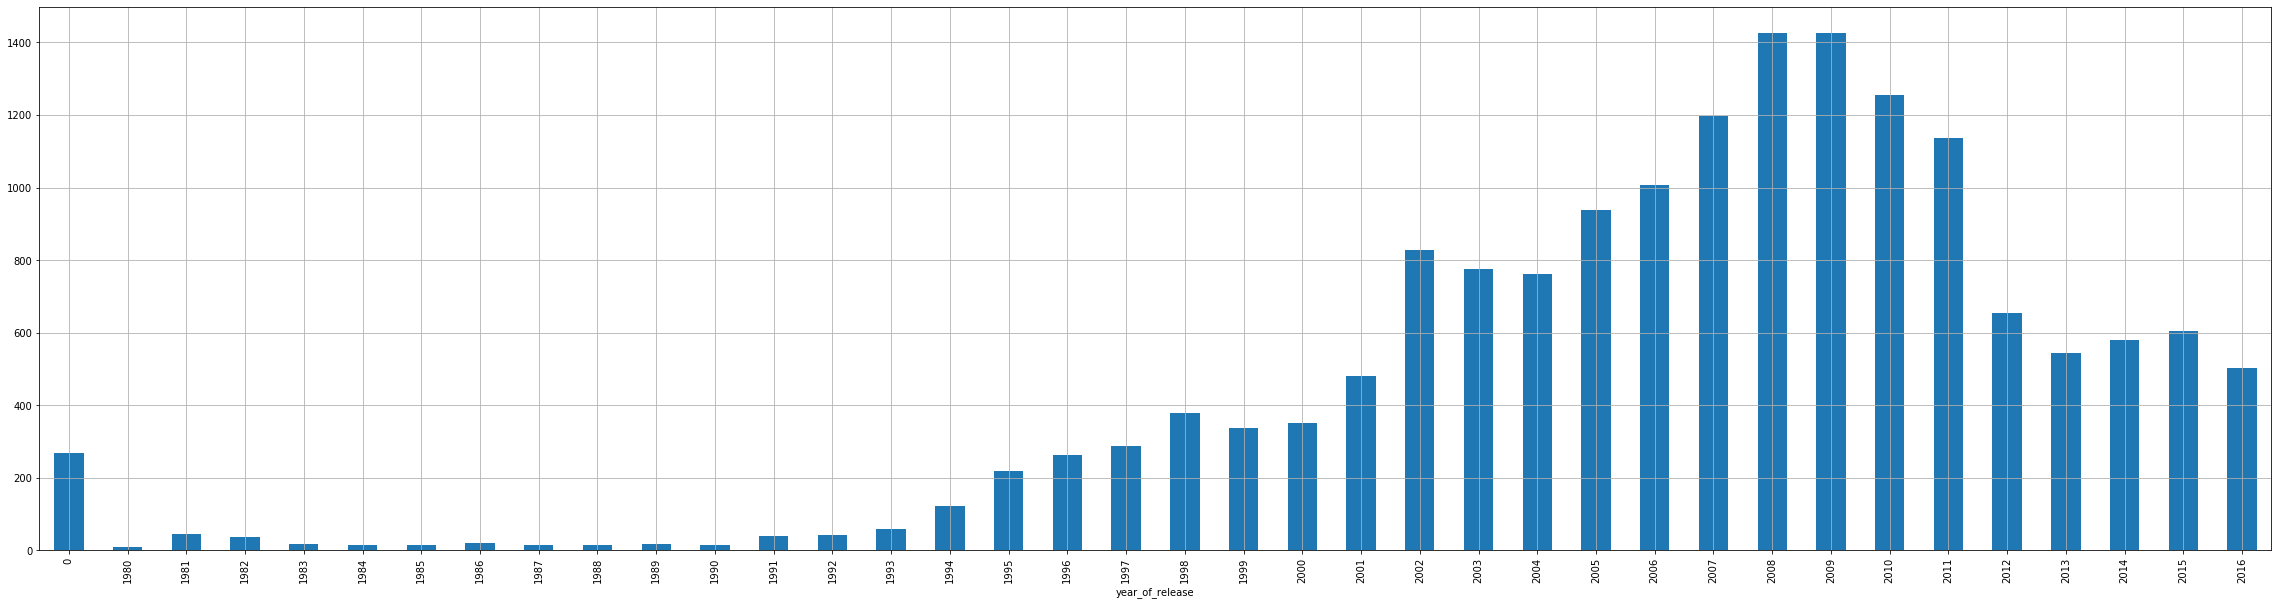

In [12]:
games.groupby('year_of_release')['name'].count().plot(kind='bar', grid=True, figsize=(40,10))

В 1980-е игр выпускалось очень мало, редко больше 20 штук в год. В первой половине 1990-х начался рост, который во второй половине десятилетия ускорился. В 2002 году произошел резкий скачок с последующим незначительным спадом, а на 2008-2009 гг. пришелся пик: в год выходило более 1400 игр. Затем рынок начал сокращаться, а в 2012 г. произошел настоящий обвал, после которого количество релизов стабилизировалось на уровне 500-600 штук в год.

Это картина по датасету в целом. А что будет, если рассмотреть отдельно игры, для которых нет ни одного отзыва, и игры, для которых есть хотя бы один? 

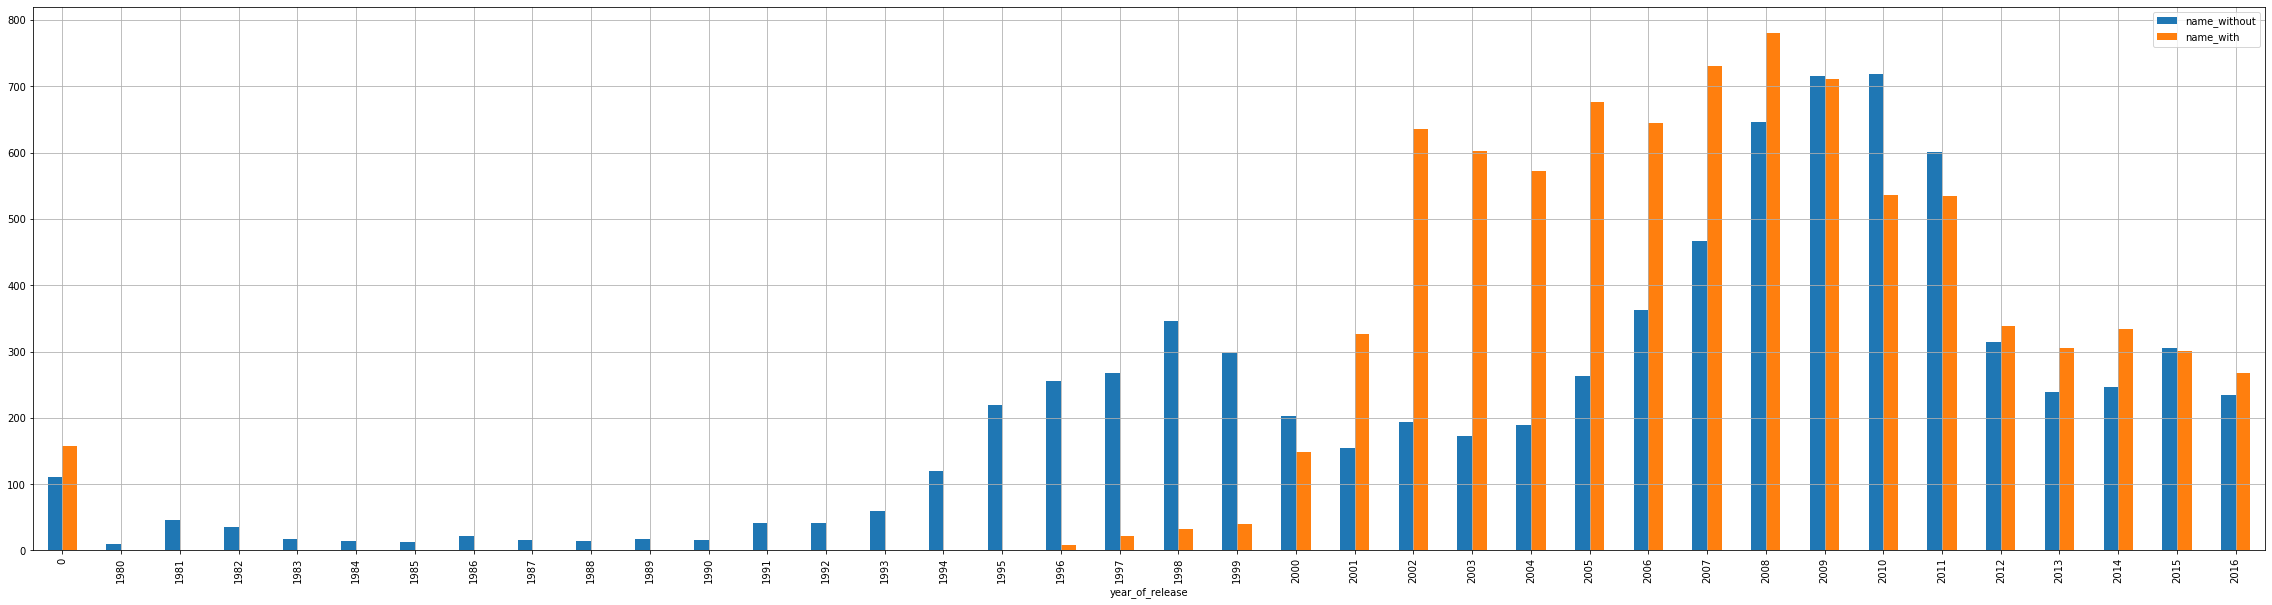

In [13]:
score = games.loc[
    (games['critic_score'].isnull()) & 
    (games['user_score'].isnull())
].groupby('year_of_release')['name'].count().to_frame().merge(
    games.loc[
    ~(games['critic_score'].isnull()) | 
    ~(games['user_score'].isnull())
    ].groupby('year_of_release')['name'].count().to_frame(), 
    how='outer', on='year_of_release', suffixes=('_without','_with'))

score.plot(kind='bar', grid=True, figsize=(40,10))

Похоже, подтверждается догадка, что отсутствие отзывов имеет естественные причины. Оба графика имеют кульминацию в конце 2000х, когда достиг пика и рынок видеоигр в целом. Но на графике распределения игр без единого отзыва виден еще один пик в районе 1998 года. Сравнение с предыдущим графиком показывает, что почти все выпущенные в этом году игры не получили ни одного отзыва. О причинах этого явления судить сложно (может быть, предвестник пузыря доткомов?). Из второго графика видно, что с 2000-х количество отзывов на игры резко растет -- быстрее, чем количество самих игр, динамику изменения которого мы видели на предыдущем графике.

Построим график продаж по каждому году в датасете.

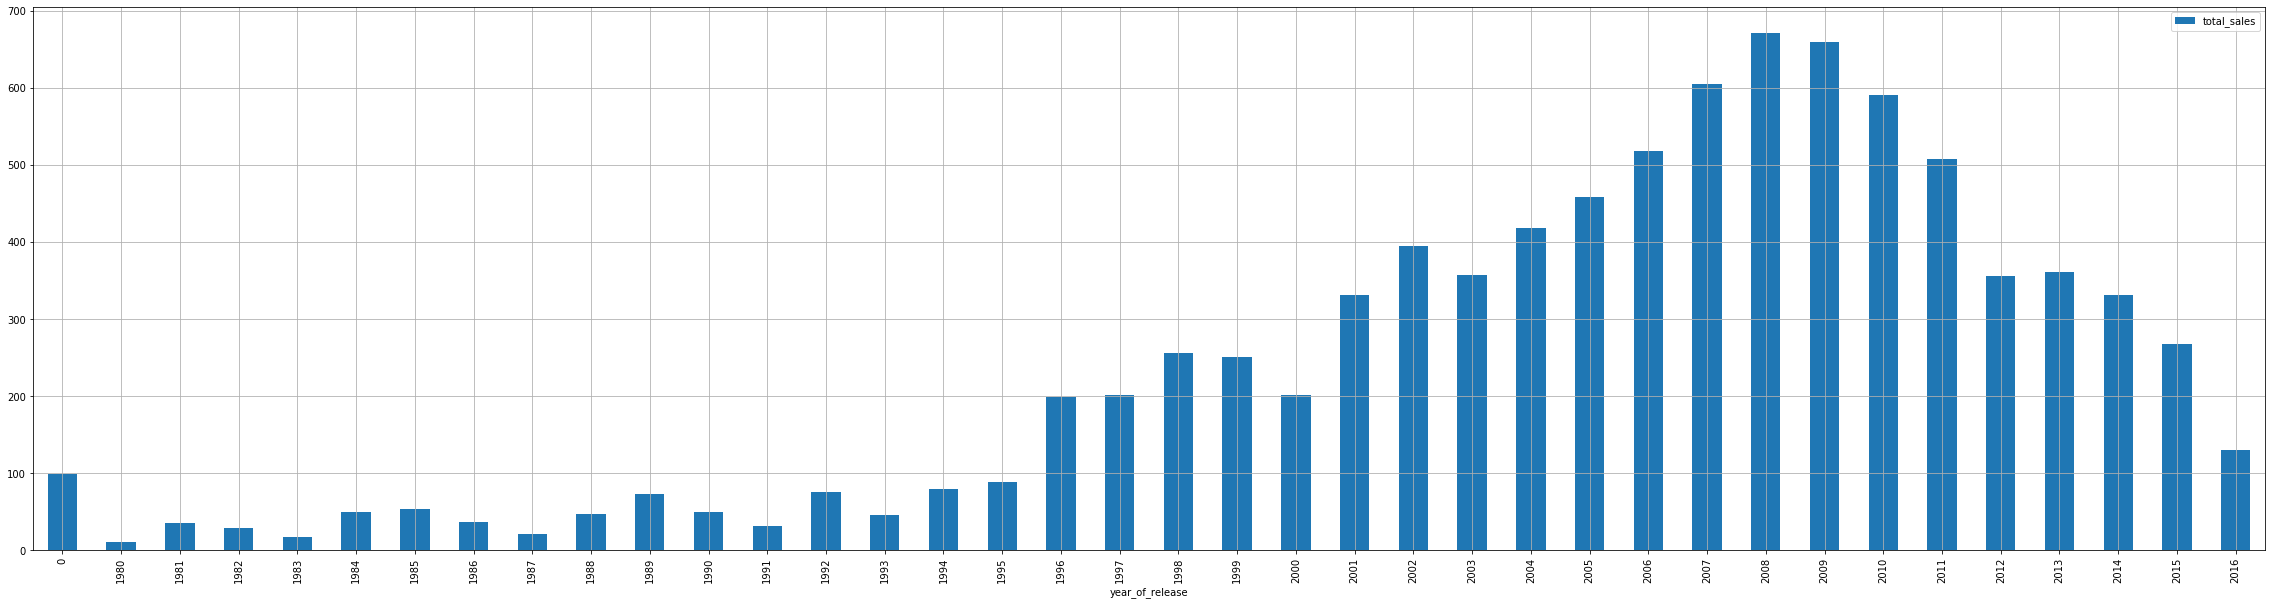

In [14]:
games.groupby('year_of_release').agg({'total_sales': 'sum'}).plot(kind='bar', figsize=(40,10), grid=True)

Он в в целом очень похож на график количества релизов по годам, но видно, что в 2009 году спрос на игры слегка просел, что стало предвестником довольно сильного сокращения количества выпускаемых игр в течение следующих лет. Наверняка это следствие мирового финансового кризиса.

Посмотрим, что покажет ящик с усами.

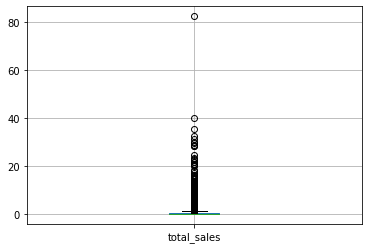

In [15]:
games.boxplot('total_sales')

Значительные выбросы над верхней границей. Применим написанную раньше функцию, чтобы увидеть ядро датасета.

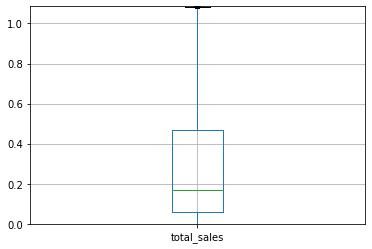

Нормальные значения: от 0 до 1.085


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38
...,...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16711,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN,0.01
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16713,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN,0.01


In [16]:
def make_boxplot(df, labels):
    for label in labels:
        q1 = df[label].describe()['25%']
        q3 = df[label].describe()['75%']
        upper_whisker = q3 + 1.5*(q3 - q1)
        lower_whisker = q1 - 1.5*(q3 - q1)
        if lower_whisker < 0:
            lower_whisker = 0
        if lower_whisker < df[label].min():
            lower_whisker = df[label].min()
        
        df.boxplot(label)
        plt.ylim(lower_whisker, upper_whisker)
        plt.show()
        print('Нормальные значения: от', lower_whisker, 'до', upper_whisker)
        
    return df 

make_boxplot(games, ['total_sales'])

В норме сумма продаж не превышает 1,1 млн. долларов, а чуть меньше половины всех выпускаемых игр не приносят создателям и двухсот тысяч. 

Для какой платформы выпущено больше всего игр?

In [17]:
games.groupby('platform').count().sort_values('name', ascending=False).head()

,name,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
platform,,,,,,,,,,,
PS2,2161,2161,2161,2161,2161,2161,2161,1298,1241,1481,2161
DS,2151,2151,2151,2151,2151,2151,2151,717,516,1273,2151
PS3,1331,1331,1331,1331,1331,1331,1331,820,877,952,1331
Wii,1320,1320,1320,1320,1320,1320,1320,585,560,1002,1320
X360,1262,1262,1262,1262,1262,1262,1262,916,966,1052,1262


В пятерке лидеров по два устройства Nintendo и Sony и одно Microsoft. Nintendo хоть и уступает Sony в общем зачете,  зато держит первенство среди мобильных платформ: для DS было выпушено всего на 10 игр меньше, чем для PlayStation 2. Неудивительно, что все пять устройств появились в продаже в 2000-е -- период, когда игровая индустрия быстро росла и, видимо, достигла своего расцвета.

Какие жанры наиболее популярны?

In [18]:
games.groupby('genre').count().sort_values('name', ascending=False).head(10)

,name,platform,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
genre,,,,,,,,,,,
Action,3369,3369,3369,3369,3369,3369,3369,1890,1830,2188,3369
Sports,2348,2348,2348,2348,2348,2348,2348,1194,1103,1509,2348
Misc,1750,1750,1750,1750,1750,1750,1750,523,439,882,1750
Role-Playing,1498,1498,1498,1498,1498,1498,1498,737,743,777,1498
Shooter,1323,1323,1323,1323,1323,1323,1323,944,924,1019,1323
Adventure,1303,1303,1303,1303,1303,1303,1303,323,300,446,1303
Racing,1249,1249,1249,1249,1249,1249,1249,742,641,872,1249
Platform,888,888,888,888,888,888,888,497,428,569,888
Simulation,873,873,873,873,873,873,873,352,344,568,873


Все довольно предсказуемо. В российской терминологии список наиболее популярных жанров будет таким (`Misc` в расчет принимать не будем):
* Экшны
* Спортивные игры
* РПГ
* Шутеры
* Квесты

Какие игры получили наибольшие и наименьшие оценки пользователей и критиков?

In [19]:
games.sort_values('critic_score', ascending=False).head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
227,Tony Hawk's Pro Skater 2,PS,2000,Sports,3.05,1.41,0.02,0.20,98.0,7.7,T,4.68
57,Grand Theft Auto IV,PS3,2008,Action,4.76,3.69,0.44,1.61,98.0,7.5,M,10.50
51,Grand Theft Auto IV,X360,2008,Action,6.76,3.07,0.14,1.03,98.0,7.9,M,11.00
5350,SoulCalibur,DC,1999,Fighting,0.00,0.00,0.34,0.00,98.0,8.8,T,0.34
165,Grand Theft Auto V,XOne,2014,Action,2.81,2.19,0.00,0.47,97.0,7.9,M,5.47


В пятерке лидеров по оценкам критиков доминирует серия GTA, причем четвертая часть игры представлена в двух версиях для разных платформ. На первом месте знаменитый симулятор скейт-парка, а на четвертом, что интересно, файтинг. Видимо, очень удачный, потому что этот жанр относится к числу наименее популярных. Тем более странно, что нет данных о продажах за пределами России.

In [20]:
games.sort_values('critic_score').head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
13689,Ride to Hell,PS3,2013,Racing,0.02,0.01,0.0,0.01,13.0,1.0,M,0.04
10662,Leisure Suit Larry: Box Office Bust,PS3,2009,Adventure,0.06,0.03,0.0,0.01,17.0,1.7,M,0.10
12822,Ride to Hell,X360,2013,Racing,0.04,0.01,0.0,0.01,19.0,1.3,M,0.06
10015,Rugby 15,PS4,2015,Sports,0.04,0.06,0.0,0.02,19.0,3.4,E,0.12
15343,Balls of Fury,Wii,2007,Sports,0.02,0.00,0.0,0.00,19.0,2.8,E10+,0.02


В антирейтинге по версии критиков -- симуляторы мотогонок (на двух платформах), регби и пинг-понга, а также один квест. Ни один официально не выходил на российском рынке. Вот и славно.

In [21]:
games.sort_values('user_score', ascending=False).head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
14412,Breath of Fire III,PSP,2005,Role-Playing,0.00,0.02,0.00,0.01,NaN,9.7,T,0.03
8975,Boktai: The Sun is in Your Hand,GBA,2003,Role-Playing,0.10,0.04,0.00,0.00,83.0,9.6,E,0.14
3417,Harvest Moon: Friends of Mineral Town,GBA,2003,Simulation,0.34,0.13,0.11,0.01,81.0,9.6,E,0.59
16546,Wade Hixton's Counter Punch,GBA,2004,Sports,0.01,0.00,0.00,0.00,78.0,9.5,T,0.01
16627,Karnaaj Rally,GBA,2003,Racing,0.01,0.00,0.00,0.00,81.0,9.5,E,0.01


В пользовательском топ-5 только мелкобюджетные игры для мобильных платформ, все изданы в первой половине двухтысячных. Никаких пересечений с фаворитами критиков.

In [22]:
games.sort_values('user_score').head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
2835,My Little Pony: Pinkie Pie's Party,DS,2008,Adventure,0.66,0.00,0.0,0.06,NaN,0.0,E,0.72
13682,Myth Makers: Trixie in Toyland,Wii,2008,Platform,0.04,0.00,0.0,0.00,NaN,0.2,E,0.04
9970,Madden NFL 17,PS3,2016,Sports,0.07,0.02,0.0,0.02,NaN,0.2,E,0.11
13380,Billy the Wizard: Rocket Broomstick Racing,Wii,2007,Racing,0.04,0.00,0.0,0.00,NaN,0.3,E,0.04
5764,Happy Feet,DS,2006,Action,0.27,0.01,0.0,0.02,NaN,0.3,E,0.30


Если судить по датасету, то, что меньше всего понравилось пользователям, критики вообще не оценивали. Лидирует квест про розового пони, которому нужно отыскать подарки ко дню рождения. Один из пользователей на Metacritic написал так: "I disliked it very much and it should be burned into fire". Интересно, что и в этом антирейтинге есть симулятор регби. По крайней мере понятно, какую игру разрабатывать точно не надо.

Судя по топ-5, отзывы критиков и пользователей между собой не коррелируют. Так ли это на самом деле?

In [23]:
games[['critic_score', 'user_score']].corr()

,critic_score,user_score
critic_score,1.000000,0.580878
user_score,0.580878,1.000000


На самом деле корреляция есть, и довольно сильная. Просто невооруженным взглядом этого не заметить.

Чтобы выделить предпочтения пользователей из разных регионов, сперва отсортируем таблицу по убыванию прибыльности в  данном регионе, затем возьмем первые сто строк из этой сортировки и последовательно сгруппируем по жанру, годам платформе и рейтингу.

In [24]:
def tops_by_region():
    regions = list(games.loc[:, 'na_sales':'other_sales'].columns)
    features = ['platform', 'year_of_release', 'genre', 'rating']
    tops_by_region = pd.DataFrame(index=range(1,6), columns=pd.MultiIndex.from_product([regions,features]))
    for region in regions:
        selection = games.sort_values(region, ascending=False).head(100)
        for feature in features:
            values = list(selection.groupby(feature).count().sort_values('name', ascending=False).head(5).index)
            for i in range(len(values)):
                tops_by_region[region, feature][i+1] = values[i] 
    return tops_by_region


# Без третьего цикла функция будет ломаться на случаях, когда выборки недостаточно для формирования списка из 
# пяти значений. Это происходит со столбцом rating. Если использовать try-except, то в таких случаях будет
# выпадать целый столбец, а не одно значение.

tops_by_region()

na_sales                                      eu_sales                  \
  platform year_of_release         genre rating platform year_of_release   
1     X360            2011       Shooter      M      PS3            2011   
2      Wii            2010      Platform      E      Wii            2010   
3       DS            2009        Action      T     X360            2013   
4      PS2            2013          Misc   E10+       DS            2009   
5      PS3            2008  Role-Playing    NaN      PS2            2005   

                       jp_sales                                       \
          genre rating platform year_of_release         genre rating   
1        Sports      E       DS            2006  Role-Playing      E   
2       Shooter      M      3DS            2009      Platform      T   
3        Action      T     SNES            1992        Sports   E10+   
4  Role-Playing   E10+      NES            2014          Misc      M   
5      Platform    NaN       GB            2008        Racing    NaN   

  other_sales                                  
     platform year_of_release    genre rating  
1         PS2            2007  Shooter      M  
2         PS3            2008   Action      E  
3         PS4            2009   Sports      T  
4         Wii            2011   Racing   E10+  
5        X360            2006     Misc    NaN

Типичный пользователь из Северной Америки играет в шутеры на Xbox 360. В соответствии с доминирующим жанром, основная аудитория там -- это люди в возрасте от 17 лет. Наиболее успешные на этом рынке игры вышли в 2011 году.

Европейские пользователи предпочитают спортивные симуляторы под Playstation 3, изданные в том же 2011 году. Преобладают игры с рейтингом "Для всех".

На российском рынке наибольшей популярностью пользуются РПГ на мобильной платформе Nintendo DS, изданные в 2006 году. Чаще всего встречается тот же рейтинг, что и в Европе -- "Для всех".

Весь остальной мир больше всего играет в довольно старые (2007 года) экшны на Playstation 2. Как и в США, здесь основной рейтинг 17+.  

Теперь c помощью библиотеки `scipy` проверим две гипотезы. В задании они сформулированы по-разному, но в обоих случаях требуется провести проверку на равенство средних двух генеральных совокупностей

Нулевая гипотеза 1: средний пользовательский рейтинг платформ PS2 и PS3 одинаковый. Альтернативная гипотеза 1: средний пользовательский рейтинг платформ PS2 и PS3 различается. Уровень статистической значимости примем равным 1%. Поскольку сравниваемые выборки представляют собой две разных генеральных совокупности, параметр `equal_var` выставим равным `False`.

In [25]:
sample_1 = games.query('platform == "PS2"')['user_score'].dropna()
sample_2 = games.query('platform == "PS3"')['user_score'].dropna()

results = st.ttest_ind(sample_1, sample_2, equal_var=False)

print('p-значение: ', results.pvalue)

p-значение:  1.6896462571938676e-45


Гипотеза о равенстве средних пользовательских рейтингов для PS2 и PS3 несостоятельна с очень высоким уровнем статистической достоверности. Средние рейтинги разные, и это почти наверняка не случайно.

Нулевая гипотеза 2: средний пользовательский рейтинг жанров Action и Sports одинаковый. Альтернативная гипотеза 2: средний пользовательский рейтинг жанров Action и Sports различается. Уровень статистической значимости снова примем равным 1%.

In [26]:
sample_1 = games.query('genre == "Action"')['user_score'].dropna()
sample_2 = games.query('genre == "Sports"')['user_score'].dropna()

results = st.ttest_ind(sample_1, sample_2)

print('p-значение: ', results.pvalue)

p-значение:  0.10406951359049141


Даже если опустить уровень статистической достоверности до 10%, нулевая гипотеза останется в силе. Средний пользовательский рейтинг игр этих двух жанров, скорее всего, действительно одинаковый.

### Выводы

Мы проанализировали рынок видеоигр за 1980-2017 годы и выяснили следующее:
* Золотой век видеоигр пришелся на 2000-е: к концу этого десятилетия и количество выпускаемых игр, и их продажи достигли максимума.
* Продажи обычно не превышает 1,085 млн. долларов, но могут быть и нулевыми. Чуть меньше половины всех выпускаемых игр не приносят создателям и двухсот тысяч.
* Список лидеров среди платформ: PS2, DS, PS3, Wii, X360.
* Топ-5 жанров: экшны, спортивные симуляторы, РПГ, шутеры, квесты.
* Серия GTA -- одна из самых успешных с точки зрения критиков. В пользовательском топ-5 только мелкобюджетные игры для мобильных платформ. Ни те, ни другие не любят симуляторы регби. Хотя на первый взгляд это неочевидно, между оценками критиков и обычных игроков есть корреляция.
* У отдельных частей игрового рынка есть особенности:
    * Типичный пользователь из Северной Америки играет в шутеры на Xbox 360. В соответствии с доминирующим жанром, основная аудитория там -- это люди в возрасте от 17 лет. Наиболее успешные на этом рынке игры вышли в 2011 году.
    * Европейские пользователи предпочитают спортивные симуляторы под Playstation 3, изданные в том же 2011 году. Преобладают игры с рейтингом "Для всех".
    * На российском рынке наибольшей популярностью пользуются РПГ на мобильной платформе Nintendo DS, изданные в 2006 году. Чаще всего встречается тот же рейтинг, что и в Европе -- "Для всех".
    * Весь остальной мир больше всего играет в довольно старые (2007 года) экшны на Playstation 2. Как и в США, здесь основной рейтинг 17+.